In [1]:
import pandas as pd
import numpy as np
from itertools import product
# might be add in requirements.txt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# Statsmodel
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
sns.set()

In [2]:
# Import the data
df_train = pd.read_csv("./train.csv", parse_dates=["datetime"])
df_train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [3]:
# Convert datetime from object to datetime type
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
# Set datetime as index
df_train = df_train.set_index(df_train.datetime)
# Drop datetime column snce it becomes our index
df_train.drop('datetime', axis=1, inplace=True)

In [4]:
# Create hour, day and month variables from datetime index --> New Features, is it worth it to add the year also? 
df_train['hour'] = df_train.index.hour
df_train['day'] = df_train.index.day
df_train['month'] = df_train.index.month
# Drop casual and registered columns, since we are predicting the count (sum of the casual and registered columns)
df_train.drop(['casual', 'registered'], axis=1, inplace=True)

In [5]:
# Check our engineerd dataset
df_train.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,5,1,1
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,6,1,1
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,3,7,1,1
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8,8,1,1


In [6]:
# We are going to use last week data as validation
horizon = 24*7 # --> data is reported by hour

# Count is our variable of interest, is what we are going to predict. 
# We use all the remaining columns as features
X = df_train.drop('count', axis=1)
y = df_train['count']

# Take last week of the dataset for validation
X_train, X_val = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_val = y.iloc[:-horizon], y.iloc[-horizon:]

# Build your model and train it (fit)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Use the trained model to predict 
predictions = reg.predict(X_val)
# Fix the predictions, we know that we cannot have -1 rented bike
predictions[predictions < 0] =0

# Calculate error  
mae = np.round(mean_absolute_error(y_val, predictions), 3)
print(f"MAPE: {mean_absolute_percentage_error(y_val, predictions)}%")
print(f"MAE: {np.round(mean_absolute_error(y_val, predictions), 3)}")



MAPE: 0.6240204472194913%
MAE: 51.047


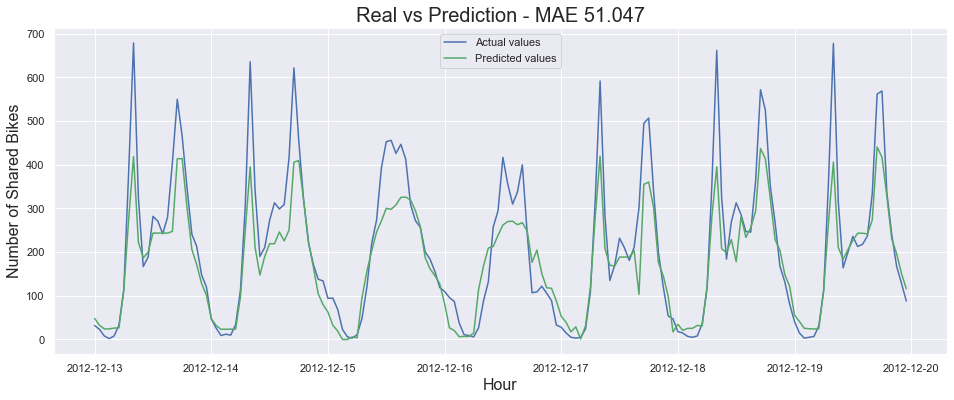

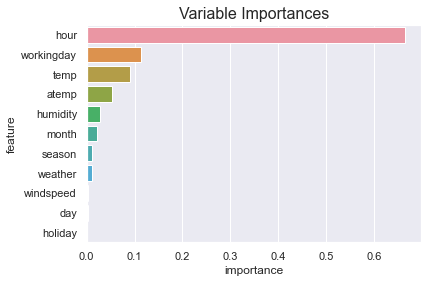

In [7]:
# Plot prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_val, label='Actual values')
plt.plot(pd.Series(predictions, index=y_val.index), 'g', label='Predicted values')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': reg.feature_names_in_,
    'importance': reg.feature_importances_
}).sort_values(by='importance', ascending=False)

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()

In [8]:
# Sometimes, if we add lags (difference between data points during a period of time) the model's performance might improve. 
# So, let's create 1 week lag variable by shifting the target value for 1 week
df_train['count_prev_week_same_hour'] = df_train['count'].shift(24*7)

# Drop NaNs after feature engineering
df_train.dropna(how='any', axis=0, inplace=True)

In [9]:
# Let's train again

# We are going to use last week data as validation
horizon = 24*7 # --> data is reported by hour

# Count is our variable of interest, is what we are going to predict. 
# We use all the remaining columns as features
X = df_train.drop('count', axis=1)
y = df_train['count']

# Take last week of the dataset for validation
X_train, X_val = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_val = y.iloc[:-horizon], y.iloc[-horizon:]

# Build your model and train it (fit)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Use the trained model to predict 
predictions = reg.predict(X_val)
# Fix the predictions, we know that we cannot have -1 rented bike
predictions[predictions < 0] =0

# Calculate error  
mae = np.round(mean_absolute_error(y_val, predictions), 3)
print(f"MAPE: {mean_absolute_percentage_error(y_val, predictions)}%")
print(f"MAE: {np.round(mean_absolute_error(y_val, predictions), 3)}")

MAPE: 0.4060435416578756%
MAE: 33.044


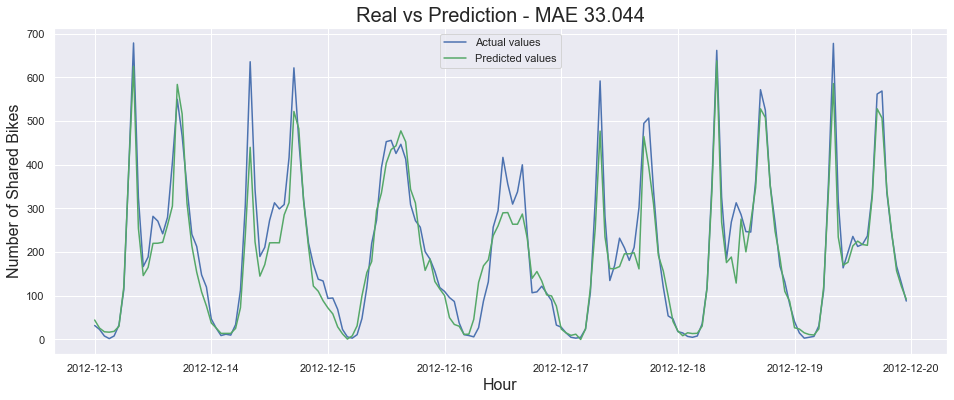

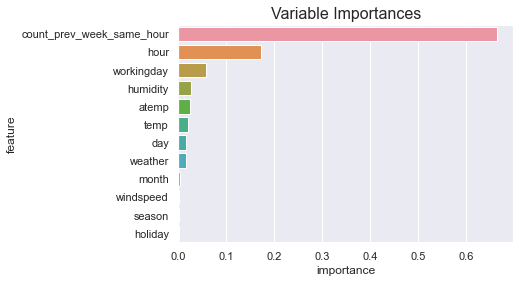

In [10]:
# Plot prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_val, label='Actual values')
plt.plot(pd.Series(predictions, index=y_val.index), 'g', label='Predicted values')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': reg.feature_names_in_,
    'importance': reg.feature_importances_
}).sort_values(by='importance', ascending=False)

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()

## Testing in the real test set

In [11]:
# Now we can create the predictions on the real test set. 
# We can use the data from the last month as training set and then, use the model to predict the following ten days.

# Import the data, again
df_train = pd.read_csv("./train.csv", parse_dates=["datetime"])
df_test = pd.read_csv("./test.csv", parse_dates=["datetime"])

# Convert datetime from object to datetime type
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
# Set datetime as index
df_train = df_train.set_index(df_train.datetime)
df_test = df_test.set_index(df_test.datetime)
# Drop datetime column snce it becomes our index
df_train.drop('datetime', axis=1, inplace=True)
df_test.drop('datetime', axis=1, inplace=True)
# Create hour, day and month variables from datetime index --> New Features, is it worth it to add the year also? 
df_train['hour'] = df_train.index.hour
df_test['hour'] = df_test.index.hour
df_train['day'] = df_train.index.day
df_test['day'] = df_test.index.day
df_train['month'] = df_train.index.month
df_test['month'] = df_test.index.month
# Drop casual and registered columns, since we are predicting the count (sum of the casual and registered columns). 
# Test set does not have them
df_train.drop(['casual', 'registered'], axis=1, inplace=True)


# We are going to use last month data from the training set to validate
horizon_train = 24*20 # --> data is reported by hour for the first 20 days of the month

# Count is our variable of interest, is what we are going to predict. 
# We use all the remaining columns as features
X = df_train.drop('count', axis=1)
y = df_train['count']

# Take last month of the dataset for validation
X_train = X.iloc[-horizon_train:,:]
y_train = y.iloc[-horizon_train:]

# We do the same for testing.
horizon_test = 24*10 # --> data is reported by hour for the last 10 days of the month
X_test = df_test.iloc[-horizon_test:,:]

# Build your model and train it (fit)
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train, y_train)

# Use the trained model to predict 
predictions = reg.predict(X_test)
# Fix the predictions, we know that we cannot have -1 rented bike
predictions[predictions < 0] =0

# Notice that we cannot calculate the error because there is no actual value to compare to. 

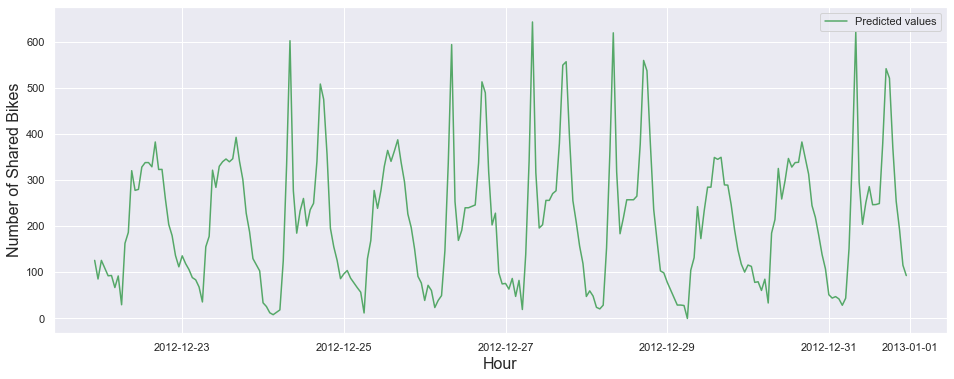

In [12]:
# Plot prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.plot(pd.Series(predictions, index=X_test.index), 'g', label='Predicted values')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()